#### Load Necessary Libraries

In [1]:
import os
import sys
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from skimage import color, io
import cv2
from PIL import Image
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage

from IPython.display import Video

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Image Compression using SVD

In this section, we will use the Singular Value Decomposition (SVD) to compress images. To do this, we will first convert an image to grayscale. We will then convert the image to a matrix of doubles. We will then use the SVD to approximate the image matrix by a matrix of lower rank. We will then use the approximation to compress the image.


## Compression Phase

To begin, we will load an image and convert it to grayscale. We will then convert the image to a matrix of doubles. The values in this matrix range from 0 to 255, where 0 represents black and 255 represents white. We will then use the SVD to approximate the image matrix by a matrix of lower rank. We will then use the approximation to compress the image.

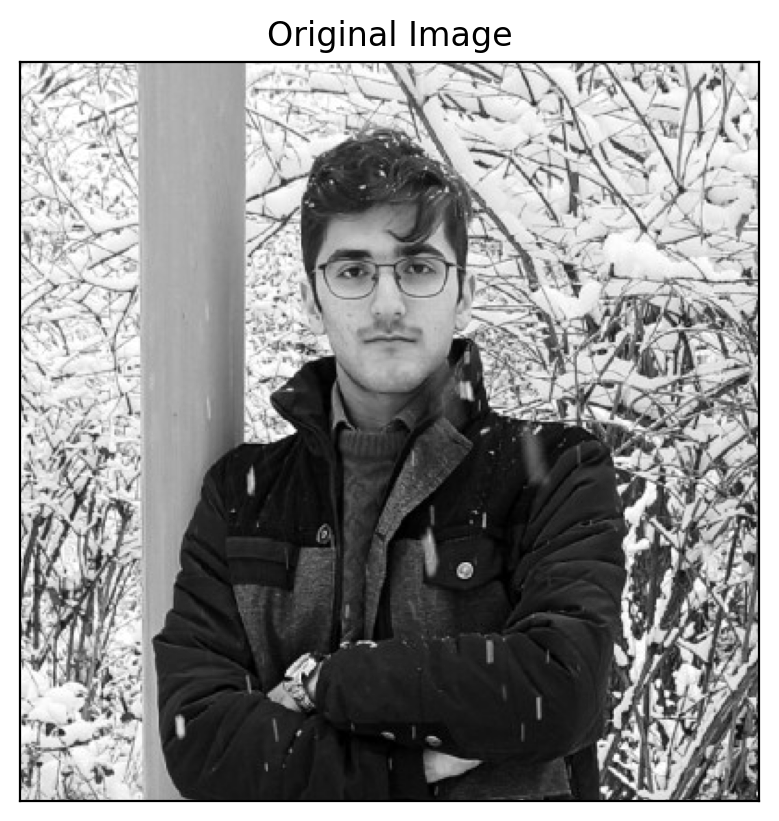

In [2]:
def load_and_preprocess_image(image_path):
    # Load the image in grayscale with cv2
    img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    return img

# Replace 'path_to_image' with the actual image path
image_path = '/content/amirreza mehrzadian.jpg'
image = load_and_preprocess_image(image_path)
plt.imshow(image, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

### Applying SVD on Image
We apply Singular Value Decomposition (SVD) on the image. We only keep the first 'k' singular values, which represent the most significant features of the image. This step compresses the image by reducing the amount of data needed to represent it.


In [3]:
def apply_svd(image):
    # Apply SVD to the image
    U, s , V = np.linalg.svd(image)
    return U , s, V


U, s, V = apply_svd(image)

#### Choosing the number of singular values to keep

The number of singular values to keep is a hyperparameter. The higher the number of singular values kept, the higher the quality of the image. However, the higher the number of singular values kept, the higher the size of the image. The number of singular values to keep is a trade-off between image quality and image size. To choose the number of singular values to keep, we can use the concept of the explained variance ratio. The explained variance ratio is the ratio of the variance explained by a singular value to the total variance. The explained variance ratio is a measure of the amount of information retained by a singular value. The explained variance ratio is calculated as follows:

$$
var_k = \frac{\sum_{i=1}^{k} \sigma_i^2}{\sum_{i=1}^{n} \sigma_i^2}
$$

where $var_k$ is the explained variance ratio, $\sigma_i$ is the $i^{th}$ singular value, and $n$ is the total number of singular values. The explained variance ratio is a measure of the amount of information retained by a singular value. A good heuristic for choosing the number of singular values to keep is to choose the smallest number of singular values that explain a certain percentage of the total variance. For example, if we want to keep 90% of the total variance, we can choose the smallest number of singular values that explain 90% of the total variance.


In [4]:
# choose the number of singular values to keep
sigman = 0.0
for i in range(len(s)):
  sigman += s[i]**2

def sigmak(s,k):
  sigmakk = 0.0
  for i in range(k-1):
    sigmakk += s[i]**2
  return sigmakk

var=0
k=1 # initial k
while True:
  var = sigmak(s,k)/sigman
  if var > 0.99:
    break
  k+=1

print('Number of singular values to keep:', k)

Number of singular values to keep: 75


### Reconstruction Phase
After applying SVD on the image, we reconstruct the image using the reduced number of singular values.

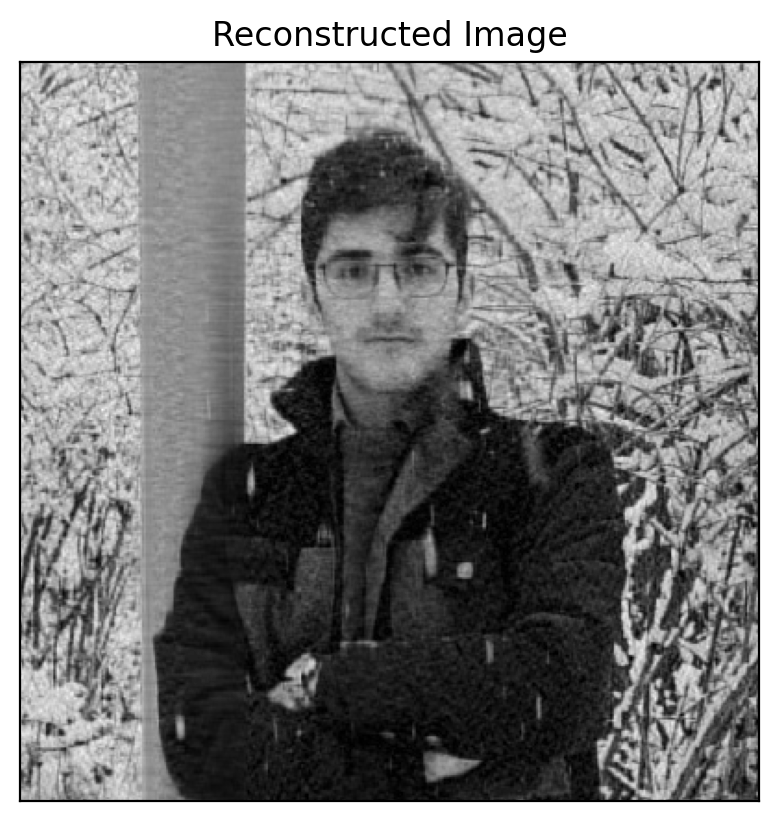

In [5]:
def reconstruct_image(U, s, V, k):
    # Reconstruct from compressed form
    K = np.zeros((k, k))
    for i in range(k):
      K[i][i] = s[i]
    U = U[:,:k]
    V = V[:k,:]

    return np.matmul(np.matmul(U, K), V)



reconstructed_image = reconstruct_image(U, s, V, k)
plt.imshow(np.abs(reconstructed_image), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Reconstructed Image')
plt.show()

# Video Background Removal

In this part, you are supposed to separate the background and foreground of a video using SVD.

In [7]:
video = mpy.VideoFileClip('/content/video (240p).mp4')
video.subclip(0, 11).ipython_display(width=500)

chunk:  57%|█████▋    | 263/464 [00:10<00:00, 602.19it/s, now=None]

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3



chunk:  57%|█████▋    | 263/464 [00:11<00:00, 602.19it/s, now=None]

MoviePy - Done.
Moviepy - Writing video __temp__.mp4




chunk:  57%|█████▋    | 263/464 [00:13<00:00, 602.19it/s, now=None]

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [8]:
def resize_frame(frame, scale):
    # Convert the NumPy array to a PIL Image
    im = Image.fromarray(frame)
    # Resize the image
    im = im.resize((int(im.width * scale), int(im.height * scale)))
    # Convert the PIL Image back to a NumPy array
    frame = np.asarray(im)
    return frame



def create_data_matrix_from_video(clip, k, scale):
    frames = []
    for i in range(k * int(clip.duration)):
        # get the frame at time i
        # convert the frame to grayscale
        # resize the frame
        frame = clip.get_frame(i / k)
        frame = rgb2grey(frame)
        frames.append(resize_frame(frame, scale))
    # stack frames horizontally
    return frames


def rgb2grey(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

In [9]:
# change resolution of image
# scale to X percent (100 means no scaling). CHANGE THIS FOR BETTER RESOLUTION
scale = 40
original_width = video.size[1]
original_height = video.size[0]

dims = (int(original_width * scale / 100), int(original_height * scale / 100))
dims  # single frame dimensions (height x width)

(144, 255)

In [ ]:
fps = 2
M = create_data_matrix_from_video(video, fps, scale)
np.save('data/video_matrix', M)
M.shape, dims

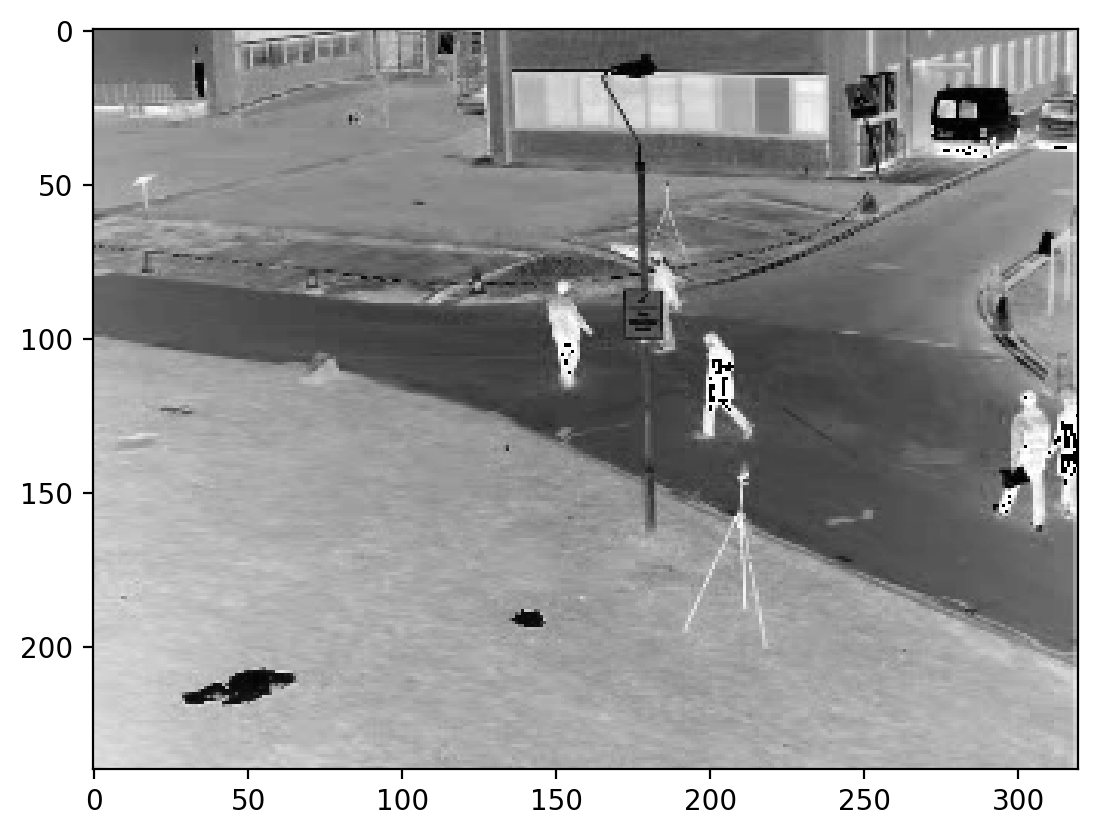

In [ ]:
test_image = M[:, 50].reshape(dims)
plt.imshow(test_image, cmap='gray')
plt.show()

In [ ]:
k = 20

# Apply SVD to the data matrix

U = U[:, :k]
s = s[:k]
Vh = Vh[:k, :]

In [ ]:
# calculate foreground from difference between original and reconstructed image

Moviepy - Building video data/people.mp4.
Moviepy - Writing video data/people.mp4



Moviepy - Done !
Moviepy - video ready data/people.mp4


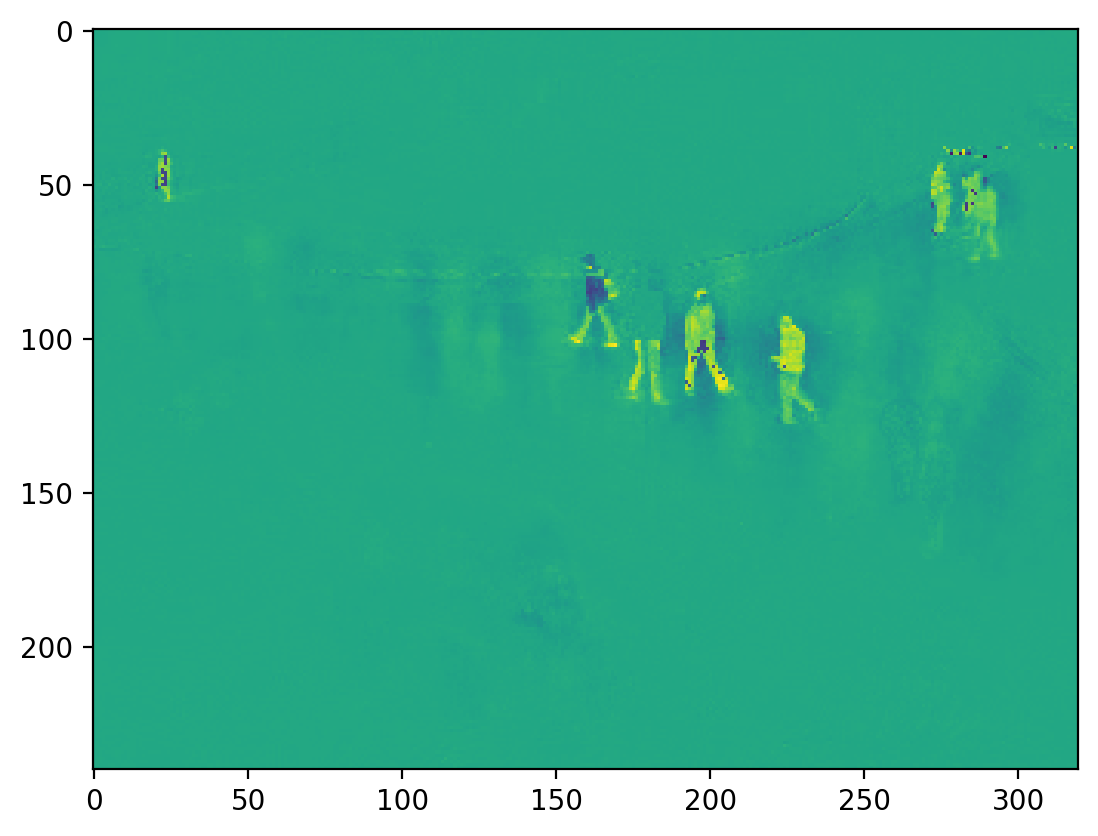

In [ ]:
foreground_frames = foreground.reshape((dims[0], dims[1], -1))

fig, ax = plt.subplots()


def make_frame(t):
    ax.clear()
    ax.imshow(foreground_frames[..., int(t*fps)], cmap='gray')
    return mplfig_to_npimage(fig)


# save video with gray color